In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
import matplotlib
from sklearn.linear_model import LogisticRegression
from IPython.display import HTML

## Setting directories

In [2]:
# Set directories and check for existence
wdir = os.path.abspath('D:\Jupyter Notebooks')
assert os.path.exists(wdir) == True

fname = 'Emergency department data.xlsx'
data = pd.read_excel(os.path.join(wdir,'data',fname), sheet_name = 0)
col_names = list(data)

## Exploratory Data Analysis 

Displaying the first 5 observations of the dataset can provide some quick insight into the nature of the dataset. At first glance, it appears that the dataset is comprised entirely of numerical (int, float, datetime values) and text data (objects). 

In [3]:
# Print first 5 observations of dataset
display(data.head())

,MRN,Presentation Visit Number,Triage Priority,Age (yrs),Arrival Date,Dr Seen Date,Depart Actual Date,Depart Status Code,Departure Status Desc.,Depart. Dest. Code,Depart. Dest. Desc.,TimeDiff Arrival-Actual Depart (mins),TimeDiff TreatDrNr-Act. Depart (mins),Presenting Complaint Code,Presenting Complaint Desc.,Diag Code,Diagnosis Desc.
0,67269,63190,3,15,2009-01-01 00:17:00,2009-01-01 02:11:00,2009-01-01 12:30:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,733,619.0,4000.0,DRUG / ALCOHOL / POISONING,F43.9,EMOTIONAL CRISIS
1,444991,63193,4,15,2009-01-01 00:35:00,2009-01-01 03:01:00,2009-01-01 07:35:00,W,DID NOT WAIT,DNW,* DID NOT WAIT,420,274.0,9000.0,INJURY,Z53.2,DID NOT WAIT
2,444992,63194,4,8,2009-01-01 00:55:00,2009-01-01 01:08:00,2009-01-01 01:08:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,13,0.0,7000.0,EYE,H10.9,CONJUNCTIVITIS
3,444999,63213,3,12,2009-01-01 03:22:00,2009-01-01 04:34:00,2009-01-01 05:00:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,98,26.0,25000.0,PAIN,H60.9,OTITIS EXTERNA
4,429921,63217,4,15,2009-01-01 03:55:00,2009-01-01 06:30:00,2009-01-01 08:29:00,H,ED SERVICE EVENT COMPLETED - DISCHARGED,DISCH,* DISCHARGED,274,119.0,9000.0,INJURY,S83.6,KNEE SPRAIN / STRAIN


We can confirm this for the entire dataset by using the following functions. It also appears that there are some values missing for the following columns: 

* Dr Seen Date
* TimeDiff TreatDrNr-Act. Depart (mins)
* Presenting Complaint Code
* Presenting Complaint Desc.

data.info()

In [4]:
# Number of null-values
data.isna().sum()

MRN                                        0
Presentation Visit Number                  0
Triage Priority                            0
 Age  (yrs)                                0
Arrival Date                               0
Dr Seen Date                             184
Depart Actual Date                         0
Depart Status Code                         0
Departure Status Desc.                     0
Depart. Dest. Code                         0
Depart. Dest. Desc.                        0
TimeDiff Arrival-Actual Depart (mins)      0
TimeDiff TreatDrNr-Act. Depart (mins)      1
Presenting Complaint Code                 19
Presenting Complaint Desc.                19
Diag Code                                  0
Diagnosis Desc.                            0
dtype: int64

It is also useful to gather some statistics on the numerical date (including datetime columns) using the pandas describe() function. 

In [5]:
data.describe()

,MRN,Presentation Visit Number,Triage Priority,Age (yrs),TimeDiff Arrival-Actual Depart (mins),TimeDiff TreatDrNr-Act. Depart (mins),Presenting Complaint Code
count,30188.000000,30188.000000,30188.000000,30188.000000,30188.000000,30187.000000,30169.000000
mean,395313.726381,32923.781834,3.265668,5.770969,204.656453,143.604797,18699.062282
std,87955.825711,21374.994159,0.686614,5.101561,176.633280,173.131043,9115.981561
min,55453.000000,254.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,351916.500000,15173.750000,3.000000,1.000000,94.000000,33.000000,9000.000000
50%,424486.000000,30254.500000,3.000000,4.000000,160.000000,87.000000,24000.000000
75%,460055.500000,46379.750000,4.000000,10.000000,262.000000,196.000000,24000.000000
max,848604.000000,79659.000000,5.000000,15.000000,5828.000000,5753.000000,73005.000000


First, it is important to note that the *MRN*, *Presentation Visit Number*, and *Presenting Complaint Code* features are only identifiers, and statistical analysis of these features will provide erroneous results/conclusions. It is best to ignore these columns. 

Aside from that, we first notice that the mean of all relevant features is higher than the median (50th percentile), which suggest that the dataset is skewed towards the left. This may suggest that we may lean towards non-parametric statistical tests during future analysis. 

## Time Series Analysis 

We can begin analyzing the dataset by performing a simple time series analysis. By looking at the number of patients that visit the emergency department for any given period, the hospital can prioritize and redistribute resources (medicial/administrative staff, rooms, imaging equipment, etc.) to appropriately account for patient influx. 

To do this, we first create 3 additional columns to separate the arrival date into hours, days, and months. Doing so will allow us to easily group observations together with respect to those values. 

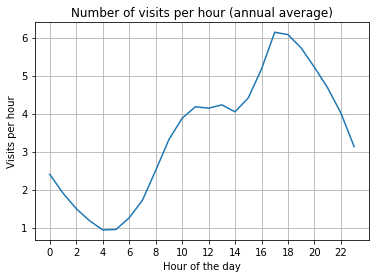

In [6]:
data['Hour'] = pd.DatetimeIndex(data['Arrival Date']).hour
data['Day'] = pd.DatetimeIndex(data['Arrival Date']).day
data['Month'] = pd.DatetimeIndex(data['Arrival Date']).month

# Number of visits per hour (annual average)
ax = pd.DataFrame(data.groupby(data['Hour']).count()['MRN']/365).plot(
        legend = False, grid = True)
ax.set_xticks(range(0,24,2))
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Visits per hour')
ax.set_title('Number of visits per hour (annual average)')
plt.show()

Here, we can see that peak times are around 17:00 - 18:00 (5 - 6 PM), which could suggest that school and parental work schedules may be a probable cause of influx during those times. After that, visits per hour steadily decreases until a low of 1 visit per hour at around 04:00 (4 AM). Note that this graph (and subsequent time series analysis plots) can be further broken down into age groups or other features to understand further dependencies.

Similary, we can do the same with respect to the day of the month and month of the year. 

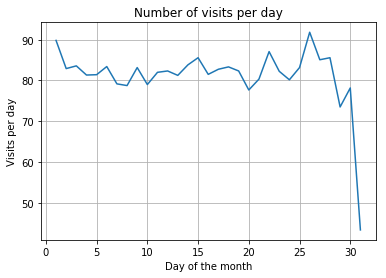

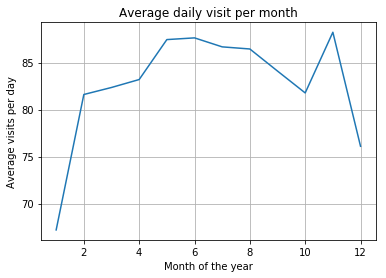

In [7]:
# Number of visits per day 
ax = pd.DataFrame(data.groupby(data['Day']).count()['MRN']/12).plot(
        legend = False, grid = True)
#ax.set_xticks(range(1,13))
ax.set_xlabel('Day of the month')
ax.set_ylabel('Visits per day')
ax.set_title('Number of visits per day')

# Number of visits per day 
dpm = [31,28,31,30,31,30,31,31,30,31,30,31]
ax = pd.DataFrame(data.groupby(data['Month']).count()['MRN']/dpm).plot(
        legend = False, grid = True)
#ax.set_xticks(range(1,13))
ax.set_xlabel('Month of the year')
ax.set_ylabel('Average visits per day')
ax.set_title('Average daily visit per month')
plt.show()

From the first plot, we notice that there is little time dependence across the days of the month, until the 29th day. This is due to different months having different a different number of days with many months not having a 31st day.

For the same reason, the second plot shows the average visits per day for each month of the year. This is because we normalize the total counts for each month by the number of days in said month. This allows us to compare each month without worrying about that dependency. In this plot, we can see that the months of December and January have the lowest average daily visits, possibly due to families leaving the city for holidays. The average daily visits peak around November, which correlates to the timing of influenza season, however, further analysis of the diagnosis data is needed to confirm this claim. 

## Demographic of patients

Now, we will explore the characteristics of the patients that visit the emergency department. We can still off by looking at the age distribution.

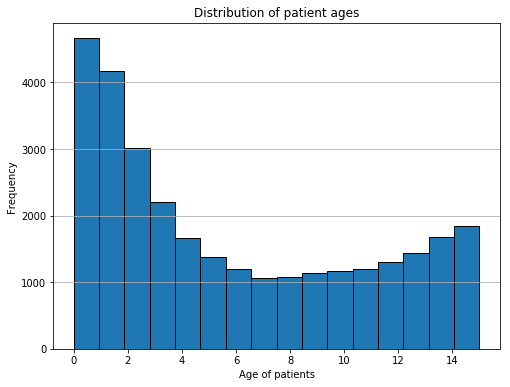

In [8]:
## Age of patients 
ax = data[' Age  (yrs)'].plot(kind = 'hist', bins = 16, ec = 'black', figsize = (8,6))
ax.yaxis.grid()
ax.set_xlabel('Age of patients')
ax.set_title('Distribution of patient ages')
plt.show()

Patients in this dataset are given ages ranging between 0 and 15 (value of 0 corresponds to <1 year of age). We can look at the age distribution by plotting a histogram with 16 bins. Analysis of this distrubition may allow the emergency department manager to schedule staff and prioritize resources as appropriate, however, due to my unfamilarity with hospital procedures, it would be necessary to speak to a heathcare professional or manager when making inferrences from this plot. 

From this plot, we see that newborns visit the emergenecy department the most (age 0) with the frequency dropping drastically until age 7. This reduction in frequency may be correlated to the development of a child's immune system, allowing the children better innate protection from infectious diseases, resulting in less frequent doctor/hospital visits. 

The slight increase in frequency after age 7 may be a result of children transitioning into adolescence at which time they become more independent and active, which increases their risk of injuries. Evidence for both of these claims may be found by, again, looking at the age range and description of doctor diagnoses. 

We can also analyze the department status for patients that have gone through the triaging assessment and process. This will tell us more about the proportion of patients that were either admitted, left before seeing the doctor, were discharged, or were transferred to another facility.

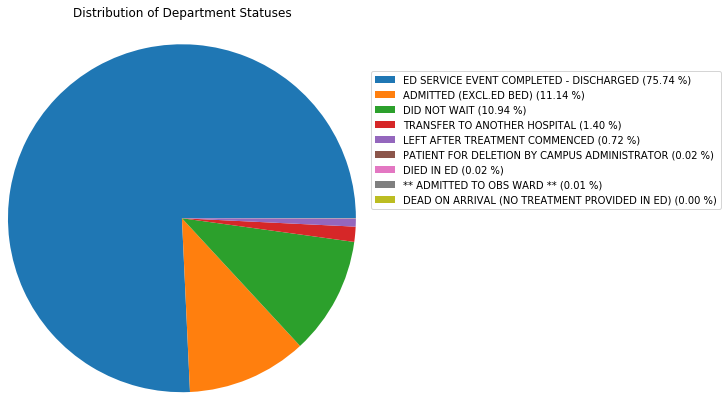

In [9]:
# Pie chart of Departure Statuses 
f = plt.figure()
j = data['Departure Status Desc.'].value_counts(normalize = True)
ax = j.plot(kind = 'pie', labels = None, radius = 2)
plt.legend(labels = ['%s (%1.2f %%)' % (l,s) for l, s in zip(j.index, j*100)], 
                     loc = 'upper right', bbox_to_anchor = (3,1.2))
ax.set_ylabel('')
ax.set_title('Distribution of Department Statuses', y = 1.4)
plt.show()

From the pie chart and reported percentages, we observe that approximately 76% of all patients complete their emergency department visit from when they arrive, are assessed, treated if appropriate, and then released. Approximately 11% of patients are admitted after seeing a doctor, and another 11% did not wait to see the doctor. These three categories make up nearly 98% of all patients that visit the emergency department. 

Similarly, we can also print out the top 10 complaints that patients (or much more likely, their parents) had presented with. 

In [10]:
# Top 10 reasons for visit 
display(data['Presenting Complaint Desc.'].value_counts(normalize = True).head(n=10))

PAEDIATRIC                     0.341410
INJURY                         0.203023
PAIN                           0.075873
RESPIRATORY                    0.072359
ENVIRONMENTAL / TEMPERATURE    0.047963
GASTROINTESTINAL               0.040406
NON EMERGENT / REVIEWS         0.026749
ENT / ORAL                     0.024396
GP REF?                        0.020650
NEUROLOGICAL                   0.019656
Name: Presenting Complaint Desc., dtype: float64

### Why did patients leave? 

Of all the patients that left before seeing a doctor, we can perform some quick statistical analysis of the features we think may contribute to their departure. [Hall & Jelinek (2007)](https://www.mja.com.au/journal/2007/187/11/characteristics-and-outcomes-patients-who-did-not-wait-after-attending-perth) looked at statistics of patients who did not wait (DNW) to be seen in a hospital emergenecy department and reported that DNW patients presented with conditions of *lower urgency*. 

Similarly, we can look at features which may indicate this phenomenon. 

In [11]:
data_dnw = data[data['Depart. Dest. Code'] == 'DNW']


triage_df = pd.DataFrame()
triage_df['Triage Priority'] = data_dnw['Triage Priority'].value_counts(
        normalize = True).index
triage_df['Proportions'] = data_dnw['Triage Priority'].value_counts(
        normalize = True).values

HTML(triage_df.to_html(index=False))

Triage Priority,Proportions
3,0.489657
4,0.443655
5,0.062674
2,0.004014


Out of all patients that did not wait, approximately 93% of them had a triage assessment of level 3 or 4, indicating that their condition was of lower urgency. We can also compare the ages of patients who did and did not wait to see a doctor. 

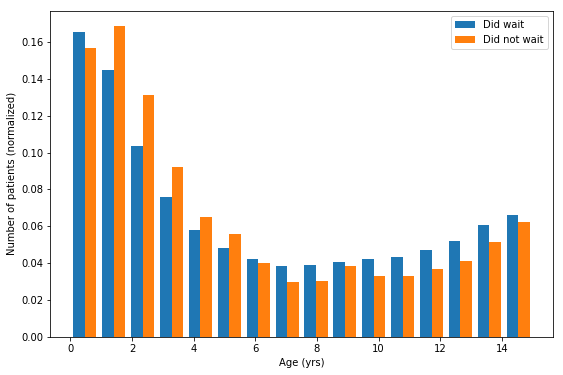

In [12]:
# Patients that did wait
data_dw = data[data['Depart. Dest. Code'] != 'DNW'].copy()
data_dw = data_dw[data_dw['Depart. Dest. Code'] != 'DNWT']
data_dw = data_dw[data_dw['Depart Status Code'] != 'W']

x1 = np.asarray(data_dw[' Age  (yrs)'])
x2 = np.asarray(data_dnw[' Age  (yrs)'])

plt.figure(figsize = (9,6))
plt.hist((x1,x2), bins = 16, histtype = 'bar', density = True)
plt.legend(labels = ['Did wait','Did not wait'])
plt.xlabel('Age (yrs)')
plt.ylabel('Number of patients (normalized)')
plt.show()

From this figure, a clear age dependence is observed from comparing the two histograms. Aside from newborns (age 0), the normalized number of patients that did not wait is higher compared to the patients that did wait. This observation carries true until age 6 where the patients that did wait overtakes the former. 

There is insufficient data to determine a cause for this effect and since it may be interpreted in more ways than one, consulting a hospital professional for contest and additional data may be required for more accurate interpretation of this phenomenon. 

## Diagnoses

Looking at the Diagnosis Desc. feature, we notice that fracture diagnoses are prefixed with a hashtag / pound sign (#). By grouping these together, we can count the number of times those fractures occur and plot their distribution. This distribution may allow staff to utilize their imaging and treatment resources more appropriately as delays in imaging may contribute to emergency department wait times. 

There may also be value in further organizing this data into groups of fracture types, for example, identifying only upper body fractures not including the head and neck. Thus, we would include the following fractures in this category: scapula & clavicle, humeral, ulnar & radial, carpal, metacarpal and thumb, as well as flail chest. These also make up the highest number of fractures in this dataset. It would also be interesting to look at the corresponding triage priorities.

Reminder that these counts are plotted in logarithmic scale. 

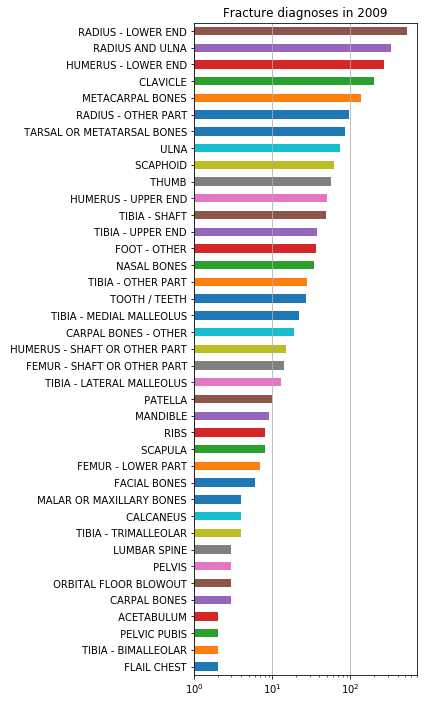

In [13]:
# Types of fractures 
frac = data['Diagnosis Desc.'][data['Diagnosis Desc.'].str.startswith('# ')]
frac = pd.Series([s.strip('#') for s in list(frac.values)])
ax = frac.value_counts().sort_values().plot(kind = 'barh', figsize = (4,12), 
                       log = True)
ax.set_title('Fracture diagnoses in 2009')
ax.xaxis.grid()

We can also create a similar plot for patients that have been admitted. The following plot shows the number of patients that have been admitted with respect to each hospital department.

Note: Counts are in logarithmic values. 

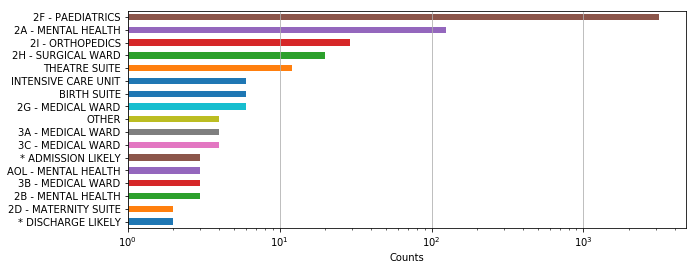

In [14]:
# Departing Destination Description for admitted patients
data_ad = data[data['Depart Status Code'] == 'A']

ax = data_ad['Depart. Dest. Desc.'].value_counts().sort_values().plot(
        kind = 'barh', log = True, figsize = (10,4))
ax.set_xlabel('Counts')
ax.xaxis.grid()

## Wait times

Wait times are major indicators of the performance and efficiencies of hospital departments. In the following example, we will examine the wait times to see doctors. We will be looking at the dataset limited to patients that did not leave before seeing the doctor (dataset filtered earlier in notebook). 

The *wait time to see a doctor* is calculated by taking the difference between the **Dr Seen Date** and the **Arrival Date**. 

In [15]:
# Time elapse to see doctor (in minutes)
delt_time = data['Dr Seen Date'] - data['Arrival Date']
data_dw['Wait time to see doctor (mins)'] = delt_time.dt.total_seconds() / 60

In addition, since wait times are likely to be heavily dependent on the triage priority, we must first group them according to that feature. We will also remove all outliers before looking at their statistics. To do this, we utilize box-plots. 

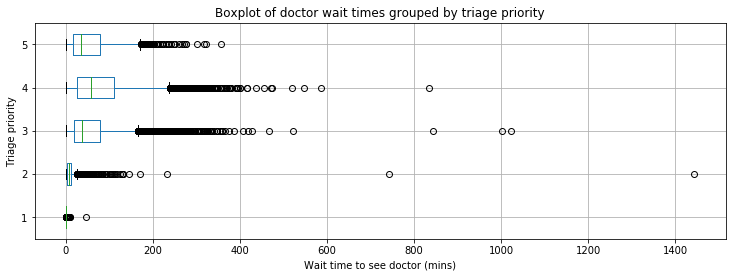

In [16]:
# Simple boxplot
ax = data_dw.boxplot(column = 'Wait time to see doctor (mins)', 
                  by = 'Triage Priority', vert = False, figsize = (12,4))
ax.set_xlabel('Wait time to see doctor (mins)')
ax.set_ylabel('Triage priority')
plt.suptitle('')
plt.title('Boxplot of doctor wait times grouped by triage priority')
plt.show()

There appears to be many outliers in the dataset that may be attributed to user error among other factors, such as the one appearing at 1450 mins (24 hours).

These outliers are filtered out according to the interquartile range for *each triage priority*. 

In [17]:
pd.set_option('mode.chained_assignment', None)

# Remove outliers using IQR
for j in range(1,6):
    temp = data_dw['Wait time to see doctor (mins)'][data_dw['Triage Priority'] == j]
    q1 = temp.quantile(0.25)
    q3 = temp.quantile(0.75)
    IQR = q3-q1
    
    # Replace with NaN
    data_dw['Wait time to see doctor (mins)'][temp.index[((temp < (q1 - 1.5*IQR)) | 
            (temp > (q3 + 1.5*IQR)))]] = np.nan

Finally, with outliers removed, we can describe their statistic:

In [18]:
df2 = data_dw.groupby('Triage Priority')['Wait time to see doctor (mins)'].describe()
display(df2)

,count,mean,std,min,25%,50%,75%,max
Triage Priority,,,,,,,,
1,203.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,2057.0,7.083131,6.013473,0.0,2.0,6.0,10.0,25.0
3,15477.0,47.570976,38.723306,0.0,17.0,35.0,70.0,165.0
4,6847.0,69.416825,55.983338,0.0,24.0,54.0,102.0,237.0
5,818.0,44.896088,39.509696,0.0,15.0,32.0,67.0,171.0


As we expected, triage priority plays an important role in determining the mean wait times to see a doctor. Patients who have high urgency conditions are assessed a triage priority of 1 and are seen immediately by doctors, resulting in zero waits. The mean wait time increases with the triage priority with the exception of triage priority = 5. The author offers the interpretation that a triage 4 patient may experience a further delay in therapy depite a higher severity ranking of their chief complaint due to access to further patient investgations, blood work results, and required imaging. This may identify a bottle neck in the emergency department work flow, and may be further assessed by the medical team to identify solutions for addressing this increased wait time in this patient group. Further interpretation of this effect should be done along with people familiar with the emergency department protocols.

# Probability of admittance 

Finally, it may useful for administrative purposes to determine the probability of a patient being admitted to the hospital. 

To do this, we will use a ***logistic regression model***. Ideally, this will use only information that is available to the administrative staff at the time of the triage assessment. 

### Selecting predictors 

Significant predictors that are available at the triage assessment stage would include the triage priority, age, and presenting complaint description. However, for this simple model, we will exclude the presenting complaint description as a predictor as the text data will need to be encoded before being input into the model. 

Another predictor that may be useful is reoccurance, which we can define as patients that are more likely to be re-admitted due to the chronic nature of their conditions. This dependency can be seen in the following plot:

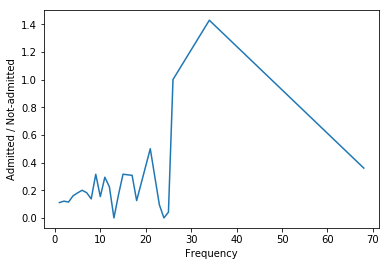

In [19]:
# Column for whether or not they were admitted
data['Admittance'] = data['Depart Status Code'] == 'A'

# Column for reoccurence of patients
data['Frequency'] = data.groupby('MRN')['MRN'].transform('count')

k = pd.crosstab(data['Frequency'],data['Admittance'])
k['Admit rate'] = k[1]/k[0]
ax = k['Admit rate'].plot()
ax.set_ylabel('Admitted / Not-admitted')
plt.show()

### Splitting dataset into training and validation subsets

Before building our model, we would like to split the dataset into subsets used for training and testing. Here, we use a 70:30 ratio for our split.

In [20]:
# Split into training and validation datasets
val_frac = int(data.shape[0]*0.7)

dw_train = data[:val_frac]
dw_val = data[val_frac:]

train_label = np.asarray(dw_train['Admittance'])
train_data = np.asarray(dw_train[[' Age  (yrs)','Triage Priority', 'Frequency']])

val_label = np.asarray(dw_val['Admittance'])
val_data = np.asarray(dw_val[[' Age  (yrs)','Triage Priority', 'Frequency']])

### Building and training the model

Before training the model, we need to normalize the dataset by taking its Z-score. Doing so allows us to directly interpret the coefficients generated by the model. 

In [21]:
# Normalize data
means = np.mean(train_data, axis = 0)
stds = np.std(train_data, axis = 0)

train_data = (train_data - means)/stds
val_data = (val_data - means)/stds

# Train model and validate model
admit_prob = LogisticRegression(solver = 'lbfgs')
admit_prob.fit(train_data, train_label)

accuracy = admit_prob.score(val_data, val_label)
print('Accuracy = ', accuracy*100, '%')

Accuracy =  89.6212874020095 %


The logistic regression model is able to predict patient admittance to an accuracy of 89.6%, based on testing on the validation dataset. 

### Model interpretation 

The coefficients in the following plot shows the significance of each predictor. As expected, the triage priority has the most significant influence on whether a patient is admitted or not, followed by the frequency, and then age. The frequency or reocurrance value is directly proportional to the probability of being admitted while the age and value of the triage assessment are inversely proportional. 

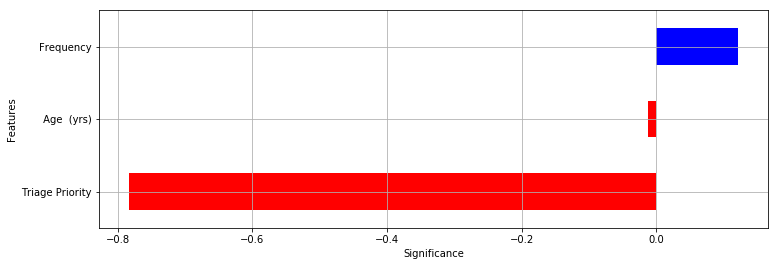

In [22]:
coeff = list(admit_prob.coef_[0])
labels = list([' Age  (yrs)','Triage Priority', 'Frequency'])

features = pd.DataFrame()
features['Features'] = labels
features['Significance'] = coeff
features.sort_values(by = 'Significance', ascending = True, inplace = True)
features['cmap'] = features['Significance'] > 0
features.set_index('Features', inplace = True)
features.Significance.plot(kind = 'barh', figsize = (12,4), grid = True, color = 
                         features.cmap.map({True: 'blue', False: 'red'}))
plt.xlabel('Significance')
plt.show()

# Future directions

* Analysis of **TimeDiff TreatDrNr-Act. Depart (mins)** with respect to departments to understand potential bottlenecks after diagnosis with doctor 
* Exploring the relationship between age and diagnosis descriptions 


# References

Hall J, Jelinek GA. Characteristics and outcomes of patients who "did not wait" after attending Perth public hospital emergency departments, 2000-2003. Med J Aust. 2007 Dec 3-17;187(11-12):626-9.v Available at: https://www.ncbi.nlm.nih.gov/pubmed/18072894